In [1]:
library(repr)
library(tidyverse)
library(broom)

df.all <- read.csv('results_finetune.csv')

df.all$ptask <- factor(df.all$ptask, levels=c('objdet', 'semseg', 'mulclass', 'normal'))
df.all$ftask <- factor(df.all$ftask, levels=c('objdet', 'semseg', 'sinclass'))
df.all$model <- factor(df.all$model, levels=c('r18', 'r34', 'r50', 'r101', 'r152'))
df.all$fratio <- factor(df.all$fratio, levels=c(1,2,4,7,10,16,32,64,100))

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



`summarise()` has grouped output by 'pretrain.data', 'pscale', 'ptask', 'fdata', 'fratio', 'ftask', 'model', 'nparam', 'pdata'. You can override using the `.groups` argument.



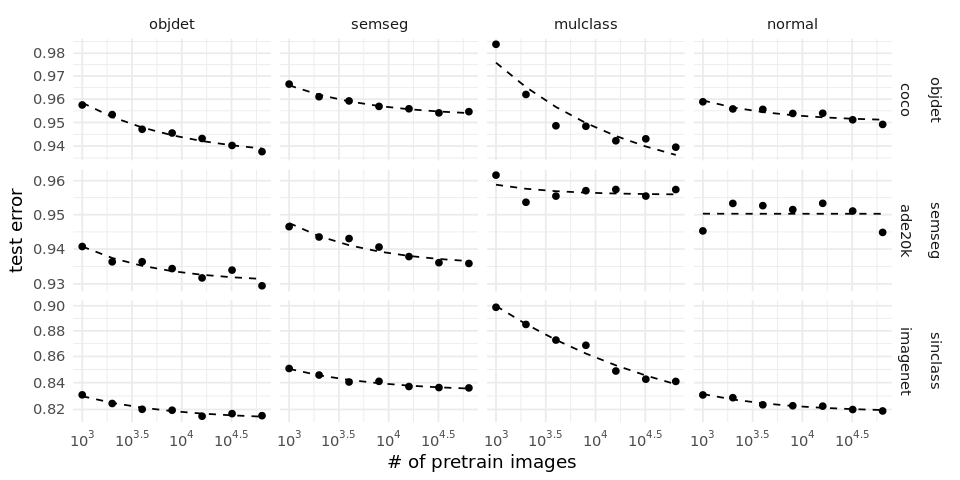

In [2]:
get.df.max <- function(df){
    df %>% 
        filter(!is.na(value)) %>%
        group_by(across(c(-n_eval, -value))) %>%
        mutate(last.value=value[n_eval == max(n_eval)]) %>%
        group_by(across(c(-n_eval, -value))) %>%
        summarise(max = max(value, na.rm=T)) 
}
fit.scalinglaw <- function(df){
    df %>%
    mutate(x = pretrain.data, y = 1 - last.value) %>%
    group_by(model, ptask, pdata, ftask, fdata, fratio) %>%
    nest() %>%
    mutate(
            fit=map(data, ~ nls(y ~ c + 0.48 * x^-a, data=., start=c(a=0.2, c=0.8), 
                    alg='port', lower=c(a=0.1, c=0), upper=c(a=1.5, c=1))),        
            augmented=map(fit, augment),
            tidied=map(fit, tidy),
            ) 
}

df.nls <- df.all %>% 
    get.df.max() %>%
    filter(pdata != 'imagenet' & pretrain.data != 0) %>%
    filter(fratio == 1) %>%
    filter(pscale == '64k') %>%
    fit.scalinglaw()
    
options(repr.plot.width=8, repr.plot.height=4)
df.nls %>%
    filter(model == 'r50') %>%
    filter(pdata == 'bop') %>%
    unnest(augmented) %>%
    ggplot(aes(x=x, y=y)) +
    geom_point() +
    geom_line(aes(y=.fitted), linetype=2) +
    facet_grid(ftask + fdata ~ ptask, scale='free_y') + 
    scale_x_log10(
        breaks = scales::trans_breaks("log10", function(x) 10^x),
        labels = scales::trans_format("log10", scales::math_format(10^.x))
    ) +
    scale_y_log10() +
    xlab('# of pretrain images') +
    ylab('test error') +
    theme_minimal()